In [1]:
import os
import cv2
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
import tensorflow as tf

2024-07-15 19:29:57.654764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 19:29:57.654937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 19:29:57.961595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images = os.listdir("../input/comofod/CoMoFoD_small_v2/")
print("Total image found: {}".format(len(images)))

Total image found: 10402


In [3]:
os.makedirs("dataset/originals")
os.makedirs("dataset/forged")
os.makedirs("dataset/masks")
os.makedirs("dataset/labels")

In [4]:
for image in tqdm(images):
    if len(image.split("_")) == 2:
        if "B" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/labels/".format(image))
        elif "M" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/masks/".format(image))
        elif "O" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/originals/".format(image))
        else:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/forged/".format(image))
    if len(image.split("_")) > 2:
        if "F" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/forged/".format(image))
        elif "O" in image:
            os.system("cp ../input/comofod/CoMoFoD_small_v2/{} ./dataset/originals/".format(image))

100%|██████████| 10402/10402 [03:00<00:00, 57.49it/s]


In [5]:
print("Total masks: ", len(os.listdir("dataset/masks/")))
print("Total labels: ", len(os.listdir("dataset/labels/")))
print("Total originals: ", len(os.listdir("dataset/originals/")))
print("Total forged: ", len(os.listdir("dataset/forged/")))

Total masks:  200
Total labels:  200
Total originals:  5000
Total forged:  5000


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D, Add, Concatenate, Input
from tensorflow.keras.models import Model

def create_vgg16_fpn(input_shape=(256, 256, 3), weights_path='/kaggle/input/initial-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    # Load the pre-trained VGG16 model without top layers, and with locally stored weights
    vgg16 = VGG16(weights=None, include_top=False, input_shape=input_shape)
    vgg16.load_weights(weights_path)

    # Get the outputs of the intermediate layers
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output
    block5_conv3 = vgg16.get_layer('block5_conv3').output

    # Top-down pathway
    def conv1x1(x, filters):
        return Conv2D(filters, (1, 1), padding='same')(x)

    def conv3x3(x, filters):
        return Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    def upsample_to(x, target_shape):
        scale = (target_shape[0] // x.shape[1], target_shape[1] // x.shape[2])
        return UpSampling2D(size=scale)(x)

    # Block5
    P5 = conv1x1(block5_conv3, 256)
    
    # Block4
    P5_upsampled = upsample_to(P5, block4_conv3.shape[1:3])
    P4 = Add()([conv1x1(block4_conv3, 256), P5_upsampled])
    P4 = conv3x3(P4, 256)
    
    # Block3
    P4_upsampled = upsample_to(P4, block3_conv3.shape[1:3])
    P3 = Add()([conv1x1(block3_conv3, 256), P4_upsampled])
    P3 = conv3x3(P3, 256)
    
    # Block2
    P3_upsampled = upsample_to(P3, block2_conv2.shape[1:3])
    P2 = Add()([conv1x1(block2_conv2, 256), P3_upsampled])
    P2 = conv3x3(P2, 256)
    
    # Block1
    P2_upsampled = upsample_to(P2, block1_conv2.shape[1:3])
    P1 = Add()([conv1x1(block1_conv2, 256), P2_upsampled])
    P1 = conv3x3(P1, 256)

    # Upsample all to the same size (e.g., the size of block1_conv2)
    target_shape = block1_conv2.shape[1:3]
    P1_upsampled = P1
    P2_upsampled = upsample_to(P2, target_shape)
    P3_upsampled = upsample_to(P3, target_shape)
    P4_upsampled = upsample_to(P4, target_shape)
    P5_upsampled = upsample_to(P5, target_shape)
    
    concatenated = Concatenate()([P1_upsampled, P2_upsampled, P3_upsampled, P4_upsampled, P5_upsampled])
    
    # Final convolution layers to detect forgery
    output = Conv2D(256, (3, 3), padding='same', activation='relu')(concatenated)
    output = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(output)

    # Build the model
    model = Model(inputs=vgg16.input, outputs=output)
    return model

# Path to the downloaded weights file
weights_path = '/kaggle/input/initial-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create the model
model = create_vgg16_fpn(weights_path=weights_path)
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 20,404,801 (77.84 MB)

 Trainable params: 20,404,801 (77.84 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split


# Define target dataset directories
dataset_dir = 'dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Create target directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    for subdir in ['original', 'forged', 'masks']:
        os.makedirs(os.path.join(dir_path, subdir), exist_ok=True)

In [8]:
train_test_oriimages = sorted(os.listdir("dataset/originals"))
train_images = train_test_oriimages[:int(0.6 * len(train_test_oriimages))]
val_test_images=train_test_oriimages[int(0.6 * len(train_test_oriimages)):]
val_images = val_test_images[:int(0.75* len(val_test_images))]
test_images = val_test_images[int(0.75* len(val_test_images)):]

In [9]:
print("Training Images: {}".format(len(train_images)))
print("Validation Images: {}".format(len(val_images)))
print("Testing Images: {}".format(len(test_images)))

Training Images: 3000
Validation Images: 1500
Testing Images: 500


In [10]:
train_test_forimages = sorted(os.listdir("dataset/forged"))
train_forimages = train_test_forimages[:int(0.6 * len(train_test_forimages))]
val_test_forimages=train_test_forimages[int(0.6 * len(train_test_forimages)):]
val_forimages = val_test_forimages[:int(0.75* len(val_test_forimages))]
test_forimages = val_test_forimages[int(0.75* len(val_test_forimages)):]

print("Training Images: {}".format(len(train_forimages)))
print("Validation Images: {}".format(len(val_forimages)))
print("Testing Images: {}".format(len(test_forimages)))

Training Images: 3000
Validation Images: 1500
Testing Images: 500


In [11]:
train_test_masks = sorted(os.listdir("dataset/labels"))
train_masks = train_test_masks[:int(0.6 * len(train_test_masks))]
val_test_masks=train_test_masks[int(0.6 * len(train_test_masks)):]
val_masks = val_test_masks[:int(0.75* len(val_test_masks))]
test_masks = val_test_masks[int(0.75* len(val_test_masks)):]

print("Training Images: {}".format(len(train_masks)))
print("Validation Images: {}".format(len(val_masks)))
print("Testing Images: {}".format(len(test_masks)))

Training Images: 120
Validation Images: 60
Testing Images: 20


In [12]:
import os
import shutil

original_images_dir = '/kaggle/input/comofod/CoMoFoD_small_v2'
train_dir= '/kaggle/working/dataset/train/original'
for image in train_images:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(train_dir, image))

train_dir= '/kaggle/working/dataset/train/forged'
for image in train_forimages:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(train_dir, image))
    
train_dir= '/kaggle/working/dataset/train/masks'
for image in train_masks:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(train_dir, image))

In [13]:
test_dir= '/kaggle/working/dataset/test/original'
for image in test_images:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(test_dir, image))

test_dir= '/kaggle/working/dataset/test/forged'
for image in test_forimages:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(test_dir, image))
    
test_dir= '/kaggle/working/dataset/test/masks'
for image in test_masks:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(test_dir, image))

In [14]:
val_dir= '/kaggle/working/dataset/val/original'
for image in val_images:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(val_dir, image))
    
val_dir= '/kaggle/working/dataset/val/forged'
for image in val_forimages:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(val_dir, image))
    
val_dir= '/kaggle/working/dataset/val/masks'
for image in val_masks:
    shutil.copy(os.path.join(original_images_dir, image), os.path.join(val_dir, image))

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

# Set paths
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'
labels_dir = 'dataset/labels'

def load_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    return img_to_array(image) / 255.0

def load_mask(mask_path, target_size=(256, 256)):
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    return img_to_array(mask) / 255.0

def get_data_paths(data_dir, labels_dir):
    original_paths = sorted([os.path.join(data_dir, 'original', fname) for fname in os.listdir(os.path.join(data_dir, 'original'))])
    forged_paths = sorted([os.path.join(data_dir, 'forged', fname) for fname in os.listdir(os.path.join(data_dir, 'forged'))])
    mask_paths = {}
    
    # Check primary masks directory
    for fname in os.listdir(os.path.join(data_dir, 'masks')):
        base_name = fname.split('_')[0]
        mask_paths[base_name] = os.path.join(data_dir, 'masks', fname)
    
    # Check additional labels directory
    for fname in os.listdir(labels_dir):
        base_name = fname.split('_')[0]
        if base_name not in mask_paths:
            mask_paths[base_name] = os.path.join(labels_dir, fname)

    return original_paths, forged_paths, mask_paths

class DataGenerator(Sequence):
    def __init__(self, original_paths, forged_paths, mask_paths, batch_size=11, target_size=(256, 256), shuffle=True):
        self.original_paths = original_paths
        self.forged_paths = forged_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.original_paths) // self.batch_size

    def __getitem__(self, index):
        batch_original_paths = self.original_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_forged_paths = self.forged_paths[index*self.batch_size:(index+1)*self.batch_size]
        
        original_images = np.array([load_image(img_path, self.target_size) for img_path in batch_original_paths])
        forged_images = np.array([load_image(img_path, self.target_size) for img_path in batch_forged_paths])
        masks = np.array([load_mask(self.mask_paths[os.path.basename(img_path).split('_')[0]], self.target_size) for img_path in batch_forged_paths])
        
        return forged_images, masks

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.original_paths))
            np.random.shuffle(indices)
            self.original_paths = [self.original_paths[i] for i in indices]
            self.forged_paths = [self.forged_paths[i] for i in indices]

# Load dataset paths
train_original_paths, train_forged_paths, train_mask_paths = get_data_paths(train_dir, labels_dir)
val_original_paths, val_forged_paths, val_mask_paths = get_data_paths(val_dir, labels_dir)
test_original_paths, test_forged_paths, test_mask_paths = get_data_paths(test_dir, labels_dir)

# Create data generators
train_generator = DataGenerator(train_original_paths, train_forged_paths, train_mask_paths, batch_size=11)
val_generator = DataGenerator(val_original_paths, val_forged_paths, val_mask_paths, batch_size=11)

In [16]:
# Model training
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[reduce_lr])

# For testing
test_generator = DataGenerator(test_original_paths, test_forged_paths, test_mask_paths, batch_size=11, shuffle=False)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

model.save("fpn_vgg_20epochs.h5")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-15 19:34:40.219272: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[11,256,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,256,256,256]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-15 19:34:40.485700: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.266556499s
Trying a

272/272 ━━━━━━━━━━━━━━━━━━━━ 1935s 4s/step - accuracy: 0.9216 - loss: 0.3838 - val_accuracy: 0.9740 - val_loss: 0.0802 - learning_rate: 1.0000e-05
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1145s 4s/step - accuracy: 0.9849 - loss: 0.0385 - val_accuracy: 0.9814 - val_loss: 0.0728 - learning_rate: 1.0000e-05
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1138s 4s/step - accuracy: 0.9903 - loss: 0.0242 - val_accuracy: 0.9821 - val_loss: 0.0820 - learning_rate: 1.0000e-05
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1163s 4s/step - accuracy: 0.9926 - loss: 0.0181 - val_accuracy: 0.9845 - val_loss: 0.0773 - learning_rate: 1.0000e-05
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1143s 4s/step - accuracy: 0.9936 - loss: 0.0156 - val_accuracy: 0.9859 - val_loss: 0.0786 - learning_rate: 1.0000e-05
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1139s 4s/step - accuracy: 0.9943 - loss: 0.0139 - val_accuracy: 0.9851 - val_loss: 0.0815 - learning_rate: 1.0000e-05
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 1160s 4s/step - accurac

In [17]:
model.save("fpn_vgg16_20epochs.h5")

2024-07-16 02:11:11.327908: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[1,256,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1280,256,256]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-16 02:11:11.687260: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.359449543s
Trying algorithm eng13{} for conv (f32[1,256,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1280,256,256]{3,2,1,0}, f32[256,1280,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking 

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step


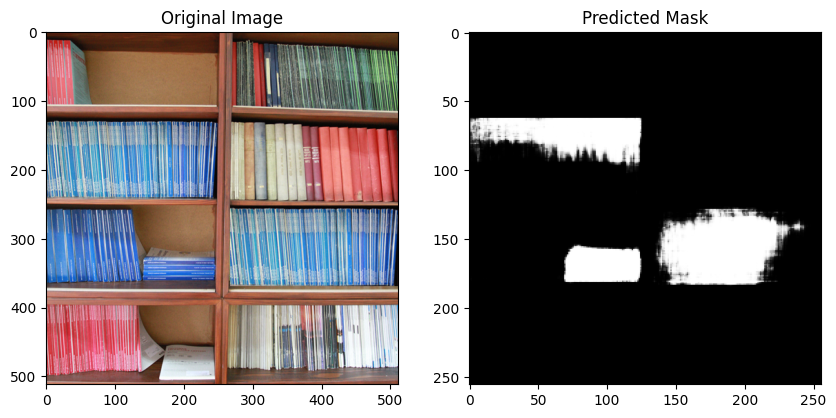

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


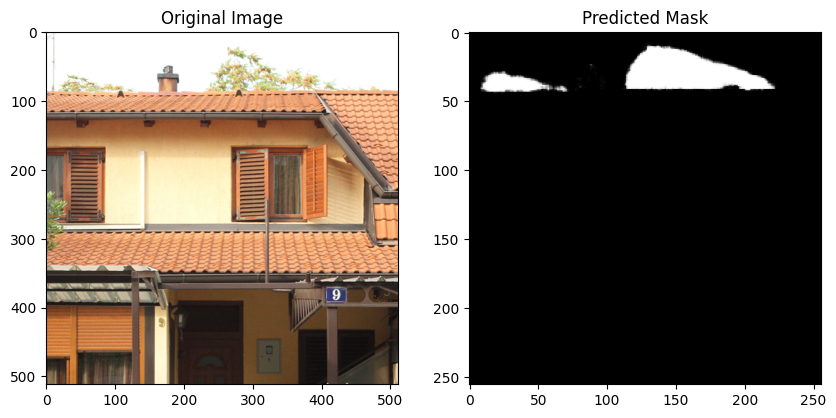

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


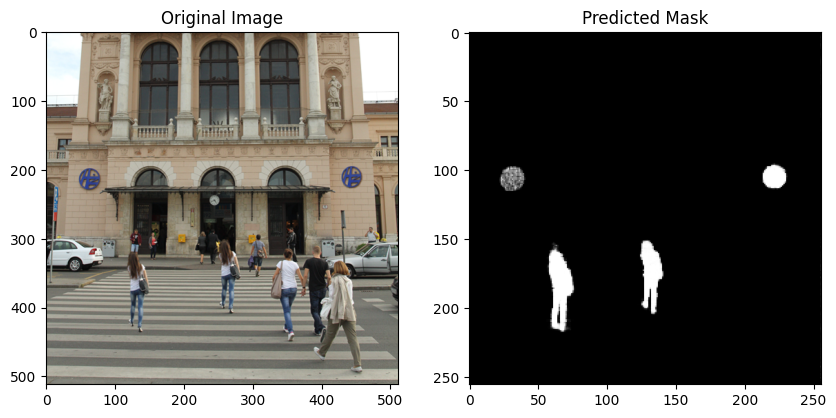

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


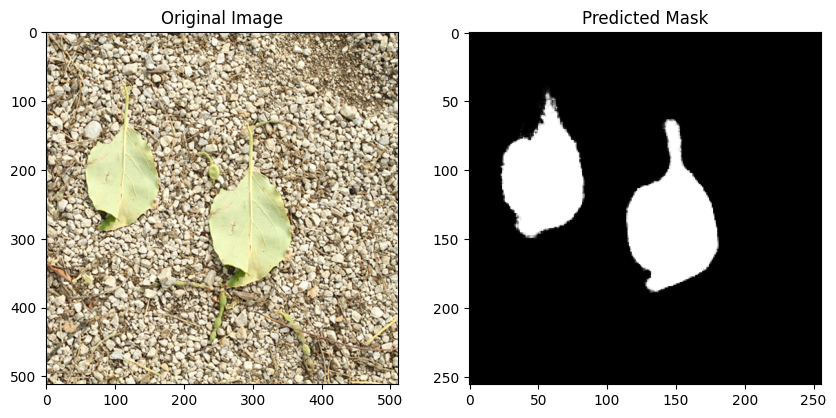

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


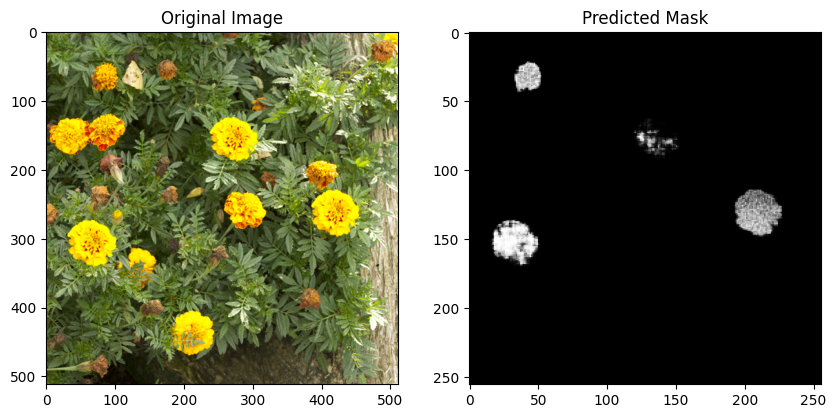

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


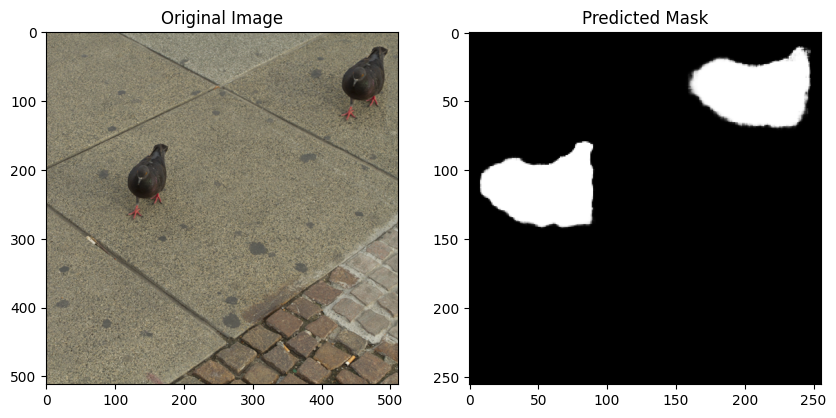

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


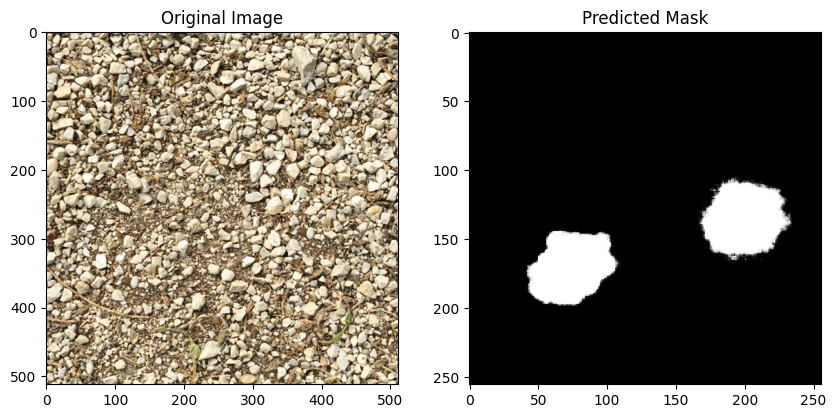

In [18]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    image = load_image(image_path, target_size)
    return np.expand_dims(image, axis=0)  # Add batch dimension

def visualize_prediction(image_path, predicted_mask):
    original_image = load_img(image_path)
    original_image = img_to_array(original_image) / 255.0

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')

    plt.show()

def process_and_visualize_images(image_paths, model):
    for image_path in image_paths:
        unseen_image = preprocess_image(image_path)
        predicted_mask = model.predict(unseen_image)
        predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension
        visualize_prediction(image_path, predicted_mask)

# List of image paths
image_paths = [
    '/kaggle/working/dataset/test/forged/184_F.png',
    '/kaggle/working/dataset/test/forged/187_F.png',
    '/kaggle/working/dataset/test/forged/190_F.png',
    '/kaggle/working/dataset/test/forged/194_F.png',
    '/kaggle/working/dataset/test/forged/200_F.png',
    '/kaggle/working/dataset/test/forged/196_F.png',
    '/kaggle/working/dataset/test/forged/185_F.png'
]

# Assuming 'model' is your trained model
process_and_visualize_images(image_paths, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


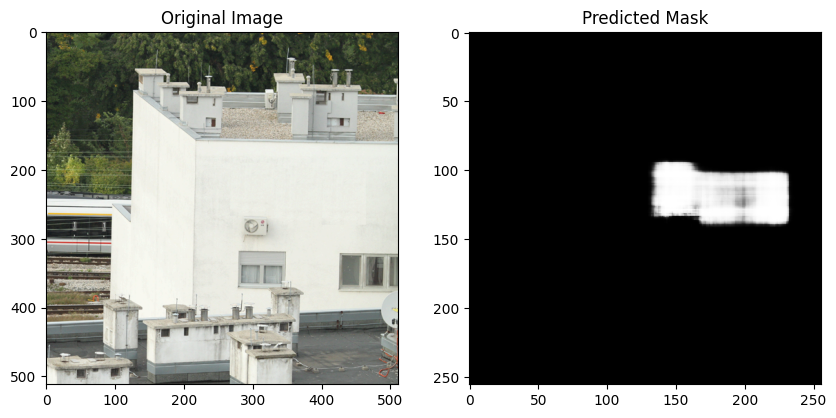

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


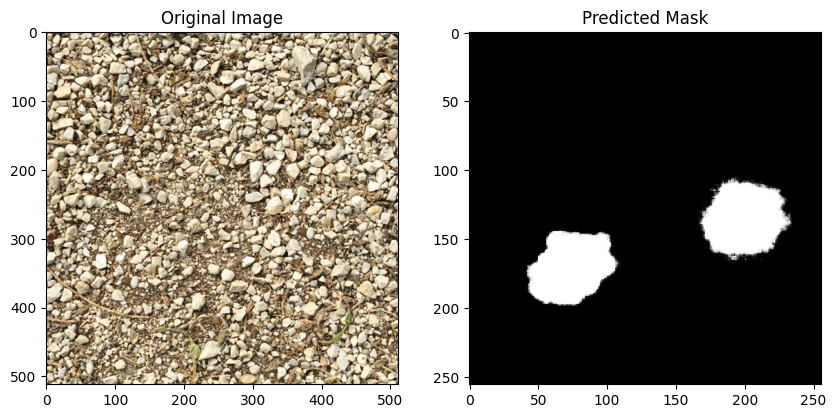

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


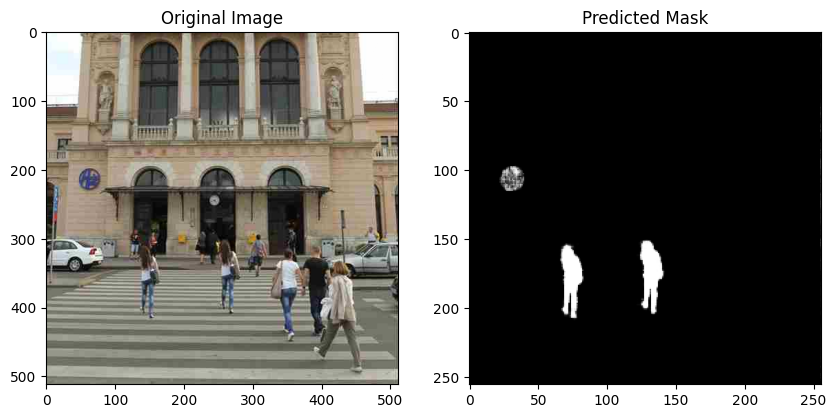

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


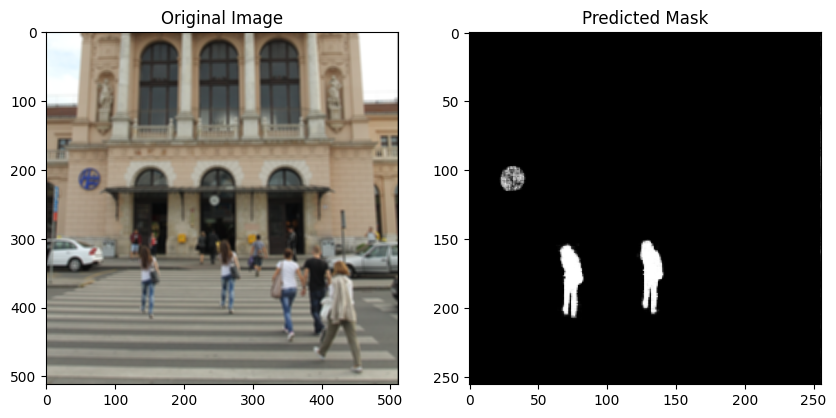

In [19]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    image = load_image(image_path, target_size)
    return np.expand_dims(image, axis=0)  # Add batch dimension

def visualize_prediction(image_path, predicted_mask):
    original_image = load_img(image_path)
    original_image = img_to_array(original_image) / 255.0

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')

    plt.show()

def process_and_visualize_images(image_paths, model):
    for image_path in image_paths:
        unseen_image = preprocess_image(image_path)
        predicted_mask = model.predict(unseen_image)
        predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension
        visualize_prediction(image_path, predicted_mask)

# List of image paths
image_paths = [
    '/kaggle/working/dataset/forged/030_F_CR2.png',
    '/kaggle/working/dataset/forged/185_F.png',
    '/kaggle/input/comofod/CoMoFoD_small_v2/001_F_JC1.jpg',
    '/kaggle/working/dataset/forged/001_F_IB2.png',
]

# Assuming 'model' is your trained model
process_and_visualize_images(image_paths, model)